In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#MNIST verisi
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Orijinal eğitim verisi şekli:", x_train.shape)  # (60000, 28, 28)
print("Orijinal test verisi şekli:", x_test.shape)     # (10000, 28, 28)

#düzleştir(flatten) (60000, 28, 28) -> (60000, 784)
x_train = x_train.reshape(-1, 784) / 255.0  # (60000, 784)
x_test = x_test.reshape(-1, 784) / 255.0    # (10000, 784)

print("Flatten eğitim verisi şekli:", x_train.shape)  # (60000, 784)
print("Flatten test verisi şekli:", x_test.shape)     # (10000, 784)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Orijinal eğitim verisi şekli: (60000, 28, 28)
Orijinal test verisi şekli: (10000, 28, 28)
Flatten eğitim verisi şekli: (60000, 784)
Flatten test verisi şekli: (10000, 784)


In [3]:
#one-hot encoding
y_train_one_hot = np.eye(10)[y_train]
print("One-hot encoded:", y_train_one_hot)  # (60000, 10)
y_test_one_hot = np.eye(10)[y_test]
print("One-hot encoded test:", y_test_one_hot)      # (10000, 10)

One-hot encoded: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
One-hot encoded test: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
def relu(x): #forward pass için ReLU aktivasyon fonksiyonu
    return np.maximum(0, x)

ReLU, negatif değerleri sıfıra çeker, pozitif değerleri olduğu gibi bırakır.

In [5]:
def relu_derivative(x): # backward pass için ReLU türevi
    # ReLU türevi, x > 0 ise 1, aksi halde 0
    return (x > 0).astype(float)

In [6]:
def softmax(x):
    # x: (sınıf_sayısı, örnek_sayısı)
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

Softmax, bir vektör içindeki değerleri 0–1 arasında normalize ederek toplamlarının 1 olmasını sağlar, yani olasılık dağılımı üretir. Genellikle çıktı katmanında kullanılır.

örn:
x = [2.0, 1.0, 0.1]

Bunları softmax ile olasılığa çeviririz:

    Tüm skorların üssünü al:

ex=[e^2.0,e^1.0,e^0.1]≈[7.39,2.71,1.11]

    Toplamını al:

∑=7.39+2.71+1.11=11.21
∑=7.39+2.71+1.11=11.21

    Normalize et:

Softmax(x)=[7.39/11.21, 2.71/11.21, 1.11/11.21]≈[0.66,0.24,0.10]

    Yani en yüksek değeri olan sınıf (2.0 → 1. sınıf) en yüksek olasılığı aldı.



In [7]:
def init_params():
    # Ağırlık ve biasları rastgele başlat
    np.random.seed(42)  # Her sefer aynı rastgele değerler için
    w1 = np.random.randn(128, 784) * 0.01
    b1 = np.zeros((128, 1))

    w2 = np.random.randn(10, 128) * 0.01
    b2 = np.zeros((10, 1))

    return w1, b1, w2, b2

In [8]:
def forward_pass(x, w1, b1, w2, b2): #x: (784,1) boyutlu bir
    z1 = np.dot(w1, x) + b1
    a1 = relu(z1)

    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)

    return z1, a1, z2, a2

In [9]:
def backward_pass(x, y, z1, a1, z2, a2, w2):
    """
    x: (784,) girdi vektörü
    y: (10,) one-hot hedef
    w1, b1, w2, b2: parametreler değişim yapabilmek için parametre olarak alırız
    """
    m = x.shape[1]  # Giriş boyutu (784,1) için 784

    # BACKWARD
    # Son katman gradyanları
    dz2 = (a2 - y)                                       # (10, 1)
    dw2 = np.dot(dz2, a1.T) / m                          # (10, 128)
    db2 = np.sum(dz2, axis=1, keepdims=True) / m         # (10, 1)

    # İlk katman gradyanları
    da1 = np.dot(w2.T, dz2)                             # (128, 1)
    dz1 = da1 * relu_derivative(z1)                     # (128, 1)
    dw1 = np.dot(dz1, x.T) / m                          # (128, 784)
    db1 = np.sum(dz1, axis=1, keepdims=True) / m        # (128, 1)

    return dw1, db1, dw2, db2


In [17]:
def calculate_accuracy(x_data, y_data, w1, b1, w2, b2):
    _, _, _, y_pred = forward_pass(x_data.T, w1, b1, w2, b2)
    predicted_classes = np.argmax(y_pred, axis=0)
    true_classes = np.argmax(y_data.T, axis=0)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy, true_classes, predicted_classes


In [11]:
def sgd_optimizer(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate=0.01):
    """
    Stochastic Gradient Descent (SGD) optimizasyonu
    w1, b1, w2, b2: Ağırlık ve biaslar
    dw1, db1, dw2, db2: Gradyanlar
    learning_rate: Öğrenme oranı
    """
    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2

    return w1, b1, w2, b2

In [12]:
def adam_optimizer(w1, b1, w2, b2, dw1, db1, dw2, db2,
                  m_w1, m_b1, m_w2, m_b2,
                  v_w1, v_b1, v_w2, v_b2,
                  t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Adam optimizasyonu
    w1, b1, w2, b2: Ağırlık ve biaslar
    dw1, db1, dw2, db2: Gradyanlar
    m_w1, m_b1, m_w2, m_b2: İlk moment tahminleri
    v_w1, v_b1, v_w2, v_b2: İkinci moment tahminleri
    t: Güncelleme adımı
    learning_rate: Öğrenme oranı
    beta1: İlk moment için beta değeri
    beta2: İkinci moment için beta değeri
    epsilon: Sıfıra bölme hatasını önlemek için küçük bir değer
    """
    # İlk moment güncellemesi
    m_w1 = beta1 * m_w1 + (1 - beta1) * dw1
    m_b1 = beta1 * m_b1 + (1 - beta1) * db1
    m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
    m_b2 = beta1 * m_b2 + (1 - beta1) * db2

    # İkinci moment güncellemesi
    v_w1 = beta2 * v_w1 + (1 - beta2) * (dw1 ** 2)
    v_b1 = beta2 * v_b1 + (1 - beta2) * (db1 ** 2)
    v_w2 = beta2 * v_w2 + (1 - beta2) * (dw2 ** 2)
    v_b2 = beta2 * v_b2 + (1 - beta2) * (db2 ** 2)

    # Bias düzeltmeleri
    m_w1_hat = m_w1 / (1 - beta1 ** t)
    m_b1_hat = m_b1 / (1 - beta1 ** t)
    m_w2_hat = m_w2 / (1 - beta1 ** t)
    m_b2_hat = m_b2 / (1 - beta1 ** t)

    v_w1_hat = v_w1 / (1 - beta2 ** t)
    v_b1_hat = v_b1 / (1 - beta2 ** t)
    v_w2_hat = v_w2 / (1 - beta2 ** t)
    v_b2_hat = v_b2 / (1 - beta2 ** t)

    # Ağırlık ve bias güncellemeleri
    w1 -= learning_rate * m_w1_hat / (np.sqrt(v_w1_hat) + epsilon)
    b1 -= learning_rate * m_b1_hat / (np.sqrt(v_b1_hat) + epsilon)
    w2 -= learning_rate * m_w2_hat / (np.sqrt(v_w2_hat) + epsilon)
    b2 -= learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)

    return w1, b1, w2, b2, m_w1, m_b1, m_w2, m_b2, v_w1, v_b1, v_w2, v_b2

In [13]:
def train(x, y, epochs=10, optimizer='sgd', learning_rate=0.01):
    # Initial parameters
    w1, b1, w2, b2 = init_params()
    losses = []
    accuracies = []

    # Adam parameters
    if optimizer == 'adam':
        m_w1, m_b1 = np.zeros_like(w1), np.zeros_like(b1)
        m_w2, m_b2 = np.zeros_like(w2), np.zeros_like(b2)
        v_w1, v_b1 = np.zeros_like(w1), np.zeros_like(b1)
        v_w2, v_b2 = np.zeros_like(w2), np.zeros_like(b2)

    # Training loop
    for epoch in range(epochs):
        # forward pass
        z1, a1, z2, a2 = forward_pass(x, w1, b1, w2, b2)

        # Loss
        loss = - np.mean(np.sum(y * np.log(a2 + 1e-8), axis=0))  # Cross-entropy loss
        losses.append(loss)

        # backward pass
        dw1, db1, dw2, db2 = backward_pass(x, y, z1, a1, z2, a2, w2)


        if optimizer == 'sgd':
            w1, b1, w2, b2 = sgd_optimizer(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate)
        elif optimizer == 'adam':
                w1, b1, w2, b2, m_w1, m_b1, m_w2, m_b2, v_w1, v_b1, v_w2, v_b2 = adam_optimizer(
                w1, b1, w2, b2, dw1, db1, dw2, db2,
                m_w1, m_b1, m_w2, m_b2, v_w1, v_b1, v_w2, v_b2,
                epoch + 1, learning_rate
            )

        if epoch % 10 == 0:
            # Doğruluk hesapla
            predictions = np.argmax(a2, axis=0)
            labels = np.argmax(y, axis=0)
            acc = np.mean(predictions == labels)
            accuracies.append(acc)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")



    return w1, b1, w2, b2, losses, accuracies

Epoch 1/150, Loss: 2.3028, Accuracy: 0.0710
Epoch 11/150, Loss: 2.0488, Accuracy: 0.6770
Epoch 21/150, Loss: 1.5169, Accuracy: 0.7370
Epoch 31/150, Loss: 0.9765, Accuracy: 0.8190
Epoch 41/150, Loss: 0.6431, Accuracy: 0.8550
Epoch 51/150, Loss: 0.4590, Accuracy: 0.8890
Epoch 61/150, Loss: 0.3499, Accuracy: 0.9200
Epoch 71/150, Loss: 0.2786, Accuracy: 0.9340
Epoch 81/150, Loss: 0.2265, Accuracy: 0.9490
Epoch 91/150, Loss: 0.1859, Accuracy: 0.9600
Epoch 101/150, Loss: 0.1532, Accuracy: 0.9750
Epoch 111/150, Loss: 0.1261, Accuracy: 0.9800
Epoch 121/150, Loss: 0.1037, Accuracy: 0.9910
Epoch 131/150, Loss: 0.0853, Accuracy: 0.9960
Epoch 141/150, Loss: 0.0704, Accuracy: 0.9970


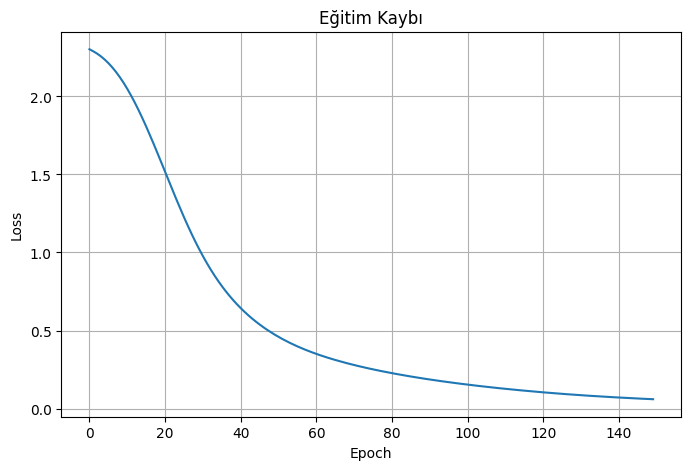

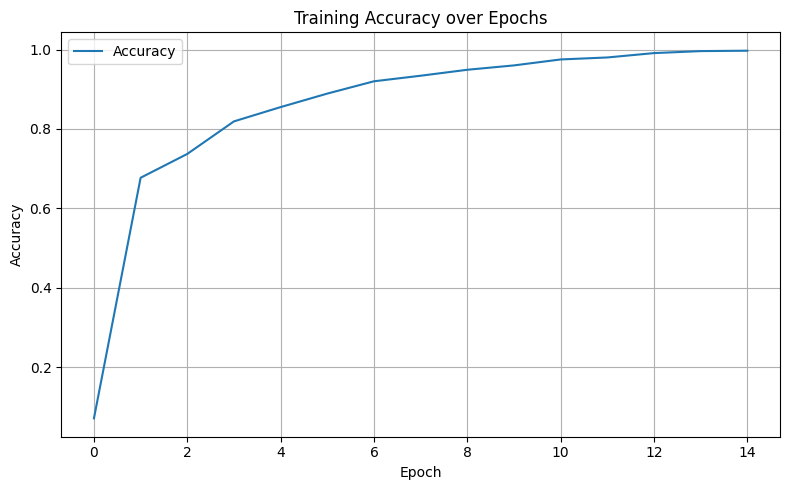

In [14]:
# adam optimizer ile deneme

x_small = x_train[:1000].T               # (784, 1000)
y_small = y_train_one_hot[:1000].T       # (10, 1000)

# Eğitim
w1, b1, w2, b2, losses, accuracy = train(x_small, y_small, epochs=150, optimizer='adam', learning_rate=0.001)

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(8, 5))


# Loss grafiği
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim Kaybı")
plt.grid(True)
plt.show()


# Accuracy grafiği
plt.figure(figsize=(8, 5))
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
accuracy, true_class, preds = calculate_accuracy(x_test, y_test_one_hot, w1, b1, w2, b2)
print(f"Test doğruluğu: {accuracy:.4f}")


Test doğruluğu: 0.8673


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def report_results(predicted_classes, true_classes, class_names=None):
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

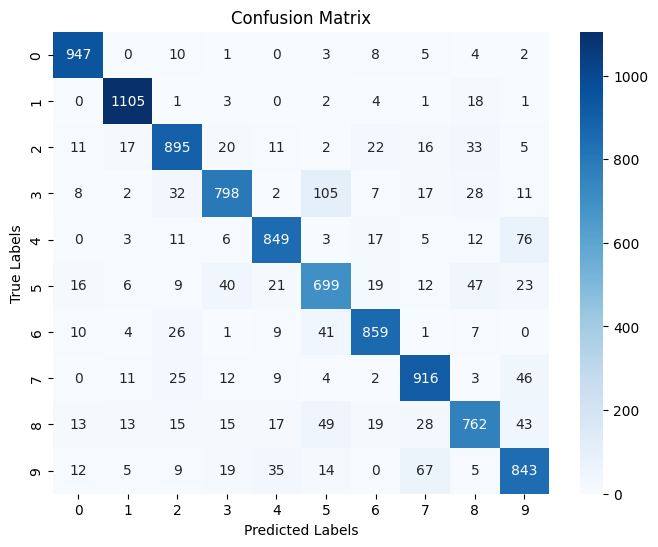


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.87      0.87      0.87      1032
           3       0.87      0.79      0.83      1010
           4       0.89      0.86      0.88       982
           5       0.76      0.78      0.77       892
           6       0.90      0.90      0.90       958
           7       0.86      0.89      0.87      1028
           8       0.83      0.78      0.81       974
           9       0.80      0.84      0.82      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.87     10000



In [21]:
class_names = [str(i) for i in range(10)]

report_results(preds, true_class, class_names)